## Machine Learning Approach for Sentiment Classification 

In the following code section you will find our machine learning approach for the sentiment classification task on the Keras IMDB dataset. 

First, we will load the dataset as done before. The input_dim describes the size of the vocabulary in the data. We used a vocabulary size of 5000 (0 - 4999). Overall, we tested the vocabulary size between 5.000 – 10.000 words to reduce the parameters and improve the performance. Second, for the output_dim (output dimension) we defined a 32 dimensional vector space in which the words will be embedded. Third, the input_lenght of the input sequences was set to 500 because we will only consider a maximum review length of 500 words, due to the distribution of review lengths seen in the boxplot in the data exploration part. As CNNs expect a fixed size of input vectors and we set the input_lenght to 500 words, we have to either truncate longer reviews or pad shorter reviews with zeros at the end when loading the data.

In [1]:
# first we import all the necessary packages for the tutorial
    # for more information please check the helperfunction.py file

from helperfunctions5 import *

import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

/Users/ninosyonan/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [3]:
# we initialize the random number generator to a constant value so that we can easily reproduce results
seed = 7
np.random.seed(seed)

In [6]:
# load the imdb data set and sequence the dataset to a maximum review length of 500 words
    # pad each document to ensure that they are of the same length of 500 for each observation
    # longer sequences are truncated and shorter sequences are padded with zeros at the end
# we will focus onlyon the first 5000 most used words in the dataset
   
top_words = 5000
max_words = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=top_words)
x_train = sequence.pad_sequences(x_train, maxlen=max_words)
x_test = sequence.pad_sequences(x_test, maxlen=max_words)

print(x_train.shape)
print(x_test.shape)
print("Documents adjusted: all reviews have the same length of",max_words,"words.")

(25000, 500)
(25000, 500)
Documents adjusted: all reviews have the same length of 500 words.


## Multilayer Perceptron Model

One of the models we chose to predict the sentiment of the IMDB dataset is a multilayer perceptron model. It is a feedforward neural network.  It consists of three layers, the input layer, the hidden layer and the output layer. It is interconnected over neurons, each of them is connected to the neurons in the next layer. We used a “Sequential” model from Keras to build the MLP. Keras defines this model as a linear stack of layers (Keras Documentation). The embedding layer which was built build already in the previous chapter Word Embeddings served as the input layer. The next step was to flatten this layer to one dimension and afterwards to add the hidden layer with 250 units. A rectifier activation function was used in this part of the model. The last layer has an output of one neuron which is binary and can have the values 0 or 1 (positive or negative). It is activated with the sigmoid function.


In [7]:
print('Build MLP model...')
model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# we used binary_crossentropy loss here because it is a binary classification problem

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Build MLP model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               4000250   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 251       
Total params: 4,160,501
Trainable params: 4,160,501
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
# running this snippet fits the model 

model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=2, batch_size=128, verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
 - 40s - loss: 0.5124 - acc: 0.7083 - val_loss: 0.3403 - val_acc: 0.8502
Epoch 2/2
 - 33s - loss: 0.1925 - acc: 0.9265 - val_loss: 0.3006 - val_acc: 0.8738


In [9]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 87.38%


As you can see, this  simple model achieved a score of nearly 87.38% which is very close to the original paper. But we can get more out of this. Therefore lets try another network model - the Concolutional Neural Networks.

____
## Convolutional Neural Networks


<img src="images/CNN.png" alt="CNN_arc" style="width: 500px;"/>
____

####  CNN Model

After performing a MLP, we conducted a one-dimensional convolutional neural network for the IMDB dataset. When looking at our dataset, an advantage for us is that Keras already provides the necessary one-dimensional convolutions as well as the Conv1D and MaxPooling1D classes. The first layer to start with is the embedding layer. After transforming the words into dense vectors they can be shifted to a convolutional layer, that with the help of the filters, indicates the proper sentiment in the sequence of words. 

In contrast to image pixels, in which the filters in the convolutional layer would slide over local patches, in NLP tasks, the filters would instead slide over full rows of the input matrix representing the words. Therefore, the width of the filters is equal compared to the width of the matrix in the embedding layer. Nevertheless, the height may vary but it is quite common to determine a sliding window of over two to five words at a time.

Next, the pooling layer is applied right after the convolutional layer.  Generally speaking, max-pooling is the most common implementation. An advantage of the pooling layer is the outcome of a fixed size output matrix. This process is inevitable because in the end the output has to be fed into the classifier. Furthermore, the operation aggregates features over a region by calculating the maximum value of the features in the region. This means that it reduces the output dimensionality while still keeping the most salient information.

Afterwards, the Flatten() operation takes the output and flattens the structure in order to create a single long feature vector, so that it can be used by the following dense layer for the final classification. The final dense layer with the activation function sigmoid transforms the output into a single output in order to indicate the sentiment.

In the end we used the binary_crossentropy loss function for our binary classification problem. Again, the Adam optimization algorithm is performed, since it is known to be very fast, efficient and had become very popular in recent deep learning model applications.


In [10]:
# Conv:
    # filter: dimensionality of the output space (32 dimensions) 
    # kernel_size: reads (window) embedded word representations 3 vector elements of the word embedding at a time
    # padding: "same" results in padding the input such that the output has the same length as the original input
    # activation: activation function to use is 'relu': relu has better properties and speeds up the training
# MaxPooling:
    # pool_size: 2 the pooling layer is used to reduce the amount of parameters to simplify the computation
# Flatten
    # to connect a Dense layer directly to an Embedding layer, flatten the 2D output matrix to a 1D vector
# Dense (sigmoid): sigmoid activation will produce a float number between 0 and 1

print('Build CNN model...')
model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(Conv1D(filters=32, 
                 kernel_size=3, 
                 padding='same', 
                 activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))



model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Build CNN model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 250)               2000250   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 251       
Total params: 2,163,605
Trainable params: 2,163,605
Non-trainable params: 0
_______________________________________________

In [11]:
# epochs: it passed 2 times through the full training set
# batch size: the number of training examples in one forward/backward pass
# vebose: 2 = one line per epoch
    # running the example (accuracy of 88.73%) offers a small improvement over the neural network model above

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=2, batch_size=128, verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
 - 38s - loss: 0.5144 - acc: 0.7116 - val_loss: 0.2850 - val_acc: 0.8810
Epoch 2/2
 - 36s - loss: 0.2240 - acc: 0.9130 - val_loss: 0.2701 - val_acc: 0.8875


In [12]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 88.75%


After two rounds we achieved quick a satisfactory outcome of 88.75% accuracy. Besides, it is an improvement compared to the end result of the MLP model we conducted earlier. Now there are a lot of opportunities to optimize and configure the model. You can play with the different settings and try to boost the performance.

In [13]:
score, acc = model.evaluate(x_test, y_test)
preds = model.predict_classes(x_test)

25000/25000 [==============================] - 10s 416us/step


#### Confusion Matrix

Calculating a confusion matrix can give you a better idea of what your classification model is getting right and what types of errors it is making. The confusion matrix below, visualizes the outcome of the binary classification:

* Total of 2813 wrong classifications and 22187 true classifications
* True negative: 11093 | False positive: 1407
* False negative: 1406 | True positive: 11094
* Accuracy: 88,75%

[[11093  1407]
 [ 1406 11094]]


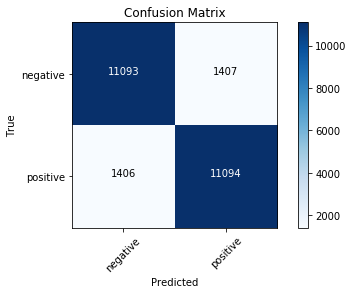

In [15]:
# we want to setup and generate a cofusion matrix to have get a better understanding of the evaluation

from sklearn.metrics import confusion_matrix, classification_report, f1_score
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
   
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')

# plot the confusion Matrix
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, {'negative': 0, 'positive': 1})

### Summary

* #### In this tutorial, we discovered the topic of Sentiment Analysis with the Keras IMDB dataset.<br><br>

* #### We learned how to develop deep learning models for sentiment analysis including:
    * How to handle the basic dictionary approach for sentiment analysis<br><br>
    * How to load review and analyze the IMDB dataset within Keras<br><br>
    * How to use and build word embeddings with the Keras Embedding Layer for deep learning<br><br>
    * How to develop a one-dimensional CNN model for sentiment analysis and how it works for NLP<br><br>
    
* #### How to continue with this tutorial?
    * Try to experiment with the number of features such as filter size in the convolutional layer<br><br>
    * You can also experiment with several convolutional layers and maxpooling layers, etc.<br><br>
    * Try to obtain higher accuracy

___
### Limitations and further Topics

* CNNs are not able to encode long-range dependencies, and therefore, for some language modeling tasks, where long-distance dependence matters, other  architectures are preferred:<br><br>
    * Recurrent Neural Networks (RNN)<br><br>
    * Long Short Term memory (LSTM) 
